In [1]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare
import model

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

# Compare the ability to predict cryptocurrency returns using machine learning and ARIMA models

###  Acquire Data Using Coinbase Pro API (account and API key required)

In [2]:
results = acquire.get_data_from_csv()

### Prepare Data:
- Data comes pretty clean from Coinbase
- The min low value for the dataset was suspiciously low. Further investigation found that there were system maintenance issues on 2017-04-15 with Coinbase. Because the low value is used to calculate a feature 

In [3]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### Bitcoin  Exploration

In [4]:
btc = prepared_results['BTC_USD']

In [5]:
btc = prepare.add_features(btc)

In [6]:
btc.index.min()

Timestamp('2016-08-24 00:00:00')

In [7]:
btc.index.max()

Timestamp('2022-04-21 00:00:00')

### Split into train, validate, test

In [8]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

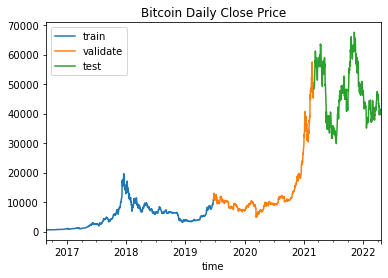

In [9]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.title('Bitcoin Daily Close Price')
plt.legend()

### Differences in split samples:
- Both train and validate include a huge runup, though only train has a large crash afterward
- Test includes a crash from highs in 2021 followed by new all time highs later in the year followed by another crash

### Target exploration:
- primary regression target is forward log returns, which is the difference in close from tomorrow to today
- classification target is whether next close is positive
- returns used (vs absolute prices) so can compare between different time series
- if assume prices are distributed log normally then log 

Text(0, 0.5, 'Frequency of Return')

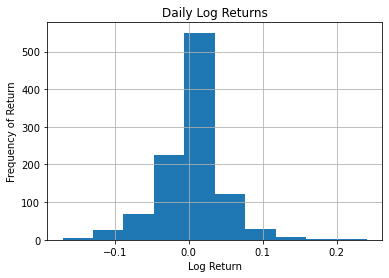

In [10]:
train.fwd_log_ret.hist()
plt.title('Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency of Return')

Text(0.5, 1.0, 'Next Close Positive (Classification Target) - fairly balanced')

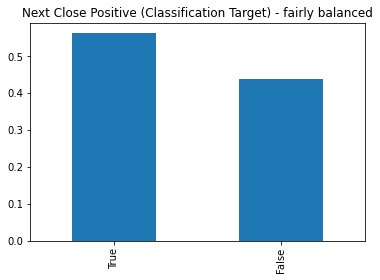

In [11]:
train.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Next Close Positive (Classification Target) - fairly balanced')

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

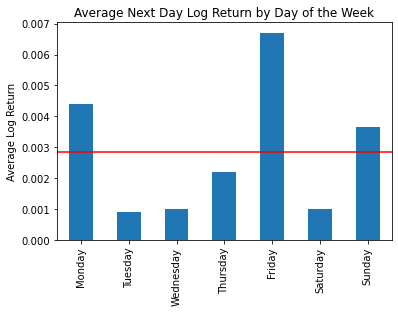

In [12]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
train.groupby(train.index.day_name()).fwd_log_ret.mean().loc[order].plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.title('Average Next Day Log Return by Day of the Week')
plt.ylabel('Average Log Return')
plt.xlabel("")
None

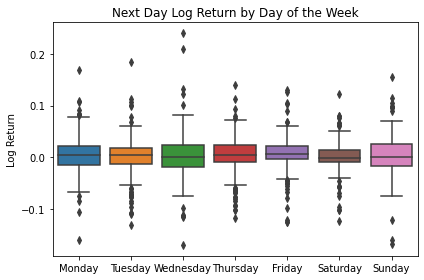

In [13]:
sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel("")
plt.ylabel("Log Return")
plt.title("Next Day Log Return by Day of the Week")
plt.tight_layout()


In [14]:
# Set alpha to 0.05
alpha = 0.05
overall_mean = train.fwd_log_ret.mean()
# Perform t-test to determine if any day's average return is significantly different from overall average
for day_of_the_week in train.index.day_name().unique():
    sample = train[train.index.day_name() == day_of_the_week]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(day_of_the_week, t, p<alpha)

Wednesday -0.4382109049371638 False
Thursday -0.19071391435173793 False
Friday 1.2220108640716778 False
Saturday -0.6757647160605057 False
Sunday 0.22803172561984486 False
Monday 0.45829650036842684 False
Tuesday -0.5432212034679261 False


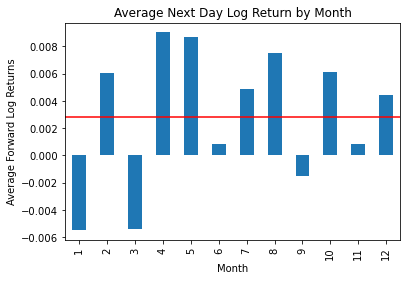

In [15]:
train.groupby(train.index.month).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.title('Average Next Day Log Return by Month')
plt.xlabel('Month')
plt.ylabel('Average Forward Log Returns')
None

In [16]:
overall_mean = train.fwd_log_ret.mean()
for month_of_year in train.index.month.unique():
    sample = train[train.index.month == month_of_year]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(month_of_year, t, p<alpha)

8 1.2273269594973495 False
9 -1.1243058735938383 False
10 1.3046282286404267 False
11 -0.4214624142362868 False
12 0.2842678944628774 False
1 -1.636415104926473 False
2 0.6457455426399578 False
3 -2.0085106074230747 True
4 1.6800486284375764 False
5 1.4088257328256801 False
6 -0.4410689548599772 False
7 0.29825054760730546 False


### Takeaways:
- All days exhibit positive log returns for the next day on average
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- No day's returns are statistically different from the overall mean
- Wednesday and Sunday have the widest spread in values, suggesting Monday and Thursday are some of the more volatile days of the week
- No month except March exhibits average returns significantly different from the overall mean

### Does the target exhibit seasonal tendencies?

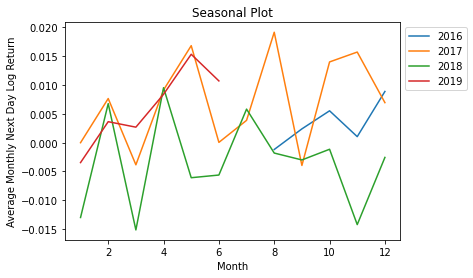

In [17]:
train.fwd_log_ret.groupby([train.index.year, train.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.xlabel("Month")
plt.ylabel("Average Monthly Next Day Log Return")
plt.legend(bbox_to_anchor=(1, 1))

### Takeaways:
- February - April exhibit some seasonality. Every March there appears to be a big dip in returns, followed by big bounce up in April
- No other months appear to show seasonality

## Lag plots and Autocorrelation

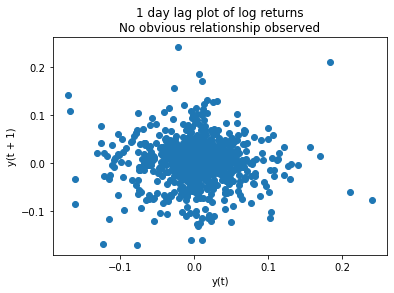

In [18]:
pd.plotting.lag_plot(train.fwd_log_ret, lag = 1)
plt.title('1 day lag plot of log returns\nNo obvious relationship observed')
None

### Lag plot of close price

Text(0.5, 1.0, '1 day lag plot of close price - today predicts tomorrow?')

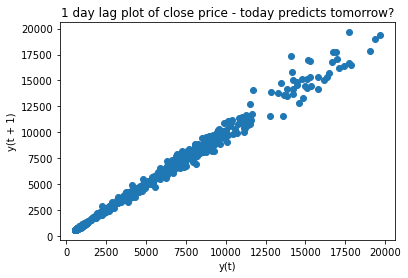

In [19]:
pd.plotting.lag_plot(train.close, lag = 1)
plt.title('1 day lag plot of close price - today predicts tomorrow?')

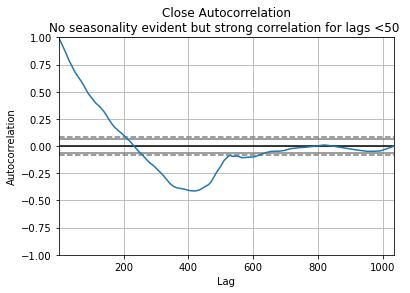

In [20]:
pd.plotting.autocorrelation_plot(train.close)
plt.title('Close Autocorrelation\nNo seasonality evident but strong correlation for lags <50 ')
None

### Features vs target

Text(0.5, 1.0, 'Next Day Log Returns vs Relative Price Range (volatility)')

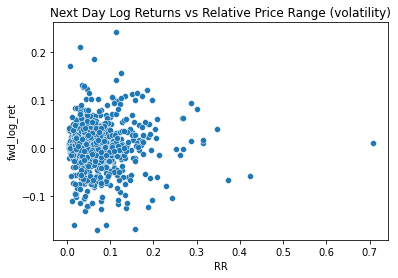

In [21]:
sns.scatterplot(train.RR, train.fwd_log_ret)
plt.title('Next Day Log Returns vs Relative Price Range (volatility)') 

### Correlations of features vs target

In [22]:
# Check correlation of every feature besides encoded day name columns
train[[col for col in train.columns if 'day_name' not in col]].corrwith(train.fwd_log_ret).sort_values(ascending=False)

fwd_log_ret           1.000000
fwd_pct_chg           0.998712
fwd_ret               0.827821
fwd_close_positive    0.667871
log_ret_lag_6         0.049871
sigma_lag_6           0.047553
sigma_lag_2           0.045426
log_ret_lag_5         0.037157
log_ret_lag_7         0.036887
log_ret_lag_3         0.031387
volume                0.031338
log_ret_lag_2         0.020126
RR                    0.018527
sigma_lag_1           0.018403
sigma_lag_7           0.015279
sigma_lag_3           0.012200
log_ret_lag_4         0.005556
log_ret_lag_1        -0.011469
pct_chg              -0.012351
sigma_lag_4          -0.016418
sigma_lag_5          -0.039582
close                -0.065933
high                 -0.066128
low                  -0.066747
open                 -0.068015
dtype: float64

### Exploration takeaways:
- Average log returns vary widely depending on the day of the week and month of the year
    - Daily dummies are included as modeling inputs
- Returns do not appear to follow any seasonal tendencies
- Lag and autocorrelation plots of log returns do not show that future returns are correlation with past returns
- Lag and autocorrelation plots of close price show a correlation with lags <50

# Modeling
- ARIMA
- Regression models

Will model log returns using ARIMA model

Determine order of ARIMA to use

In [23]:
result=adfuller(train.fwd_log_ret)
print("AD Fuller p stat < 0.05", result[1]<0.05)

AD Fuller p stat < 0.05 True


#### Augmented Dickey-Fuller test results suggest time series does not have a unit root - > it is stationary. No differencing required.

##### Determine AR (p) term

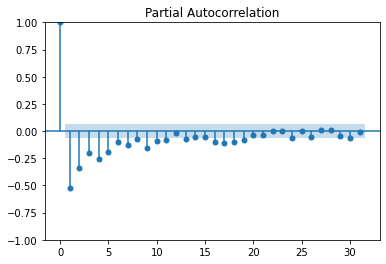

In [24]:
plot_pacf(train.fwd_log_ret.diff().dropna())
plt.show()

Looks like lags from 1-10 are significant.

##### Autocorrelation plot - MA (q) term

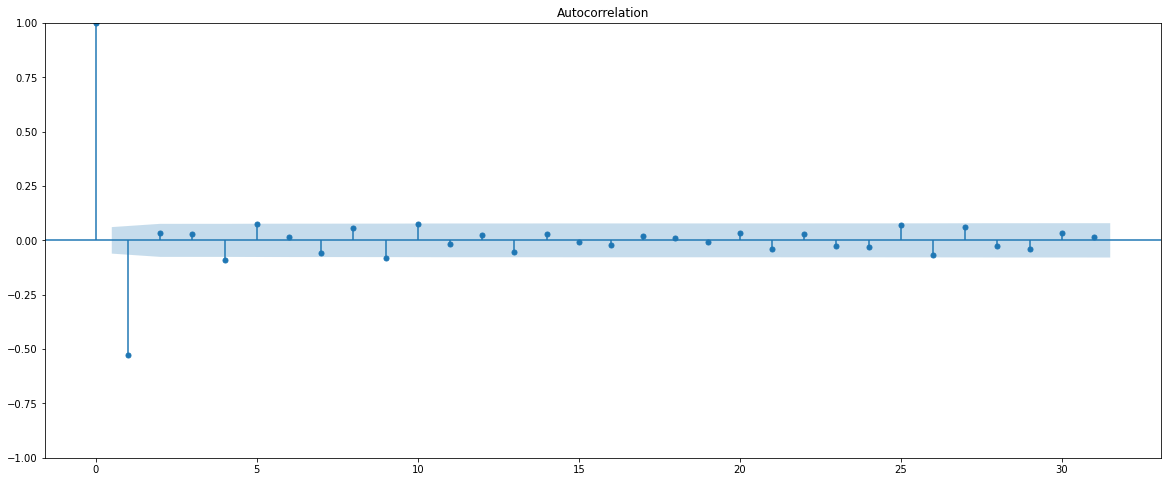

In [25]:
plt.rcParams.update({'figure.figsize':(20,8)})
plot_acf(train.fwd_log_ret.diff().dropna())
plt.show()

#### Fix q as 1

In [26]:
p_values = list(range(2,4))
d_values = [0]
q_values = [1]
results_df = model.evaluate_models(train, validate, 'fwd_log_ret', p_values, d_values, q_values)

	Testing (2, 0, 1) 619/620

	Testing (3, 0, 1) 619/620



In [27]:
real = results_df.sort_values('mse').test_actual.array[0]
# predictions = pd.Series(results_df.sort_values('mse').test_predictions.array[0], index = real.index)

results_df['rmse']= results_df.mse**0.5

results_df.sort_values('rmse')

,p,d,q,mse,test_predictions,test_actual,rmse
0,2,0,1,0.001817,"[0.0065101283954541594, 0.005818612746221494, ...",time 2019-06-23 0.018230 2019-06-24 0.06...,0.042623
1,3,0,1,0.001820,"[0.006093039300593897, 0.004250277744224532, 0...",time 2019-06-23 0.018230 2019-06-24 0.06...,0.042661


### Best ARIMA models:
- p < 5
- order (2,0,1), (3, 0, 1) - > RMSEs of 0.042623, 0.042661

In [28]:
# Build dataframe with results from top ARIMA model to determine average trade
arima_results = pd.DataFrame(index = validate.index)
arima_results["predictions"] = results_df.head(1).test_predictions[0]
arima_results["actual"] = results_df.head(1).test_actual[0].array
arima_results["close"] = validate.close
arima_results["next_day_close"] = validate.close.shift(-1)
# Create a column saying whether we would go long or not (short) based on the 
arima_results["go_long"] = arima_results['predictions']>0
# Calculate the return that day (assumes always goes long or short every day)
arima_results["ret"] = np.where(arima_results["go_long"], arima_results.next_day_close-arima_results.close, arima_results.close-arima_results.next_day_close)

print(f"Average trade based on ARMA (2,1): {arima_results.ret.mean():.2f}")

Average trade based on ARMA (2,1): 48.75


### Using Regression Models

#### Inputs:
- log returns for days 1-7
- Relative Price Range (RR) volatility indicator (for t lags 1-7):
    - 2$\frac{H_t-L_t}{H_t+L_t}$
- Parkinson range volatility estimator $\sigma$ (for t lags 1-7):
    - $\sigma$ = $\sqrt{\frac{(ln(H_t/L_t))^2}{(4*ln(2))}}$

In [29]:
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']

target = 'fwd_log_ret'

In [30]:
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = model.scale_datasets(train, validate, test, target, features_to_use, features_to_scale)

In [31]:
models = [DecisionTreeRegressor(),  SVR(kernel='linear',gamma=0.1,), LinearRegression(), TweedieRegressor(), LassoLars()]

### Iterate through regression models, uses existing train, validate, test split

In [32]:
rmses_validate, y_train, y_validate = model.predict_regression(models, X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, perform_feature_selection=False)

DecisionTreeRegressor
SVR(gamma=0.1, kernel='linear')
LinearRegression
TweedieRegressor
LassoLars


In [33]:
avg_trade_model_results =  model.calculate_regression_results(models, rmses_validate, validate, y_validate)

DecisionTreeRegressor 87.8
SVR(gamma=0.1, kernel='linear') 8.67
LinearRegression 84.36
TweedieRegressor 69.43
LassoLars 63.86


In [34]:
avg_trade_model_results.append(pd.DataFrame(data = {'avg_trade':arima_results.ret.mean(), 'rmse':results_df.head(1).rmse[0]}, index = ['ARIMA (2,0,1)']))

,avg_trade,rmse
DecisionTreeRegressor,87.803199,0.054081
LinearRegression,84.358998,0.043074
TweedieRegressor,69.428142,0.042765
LassoLars,63.856187,0.042774
buy_everyday,60.541129,NaN
"SVR(gamma=0.1, kernel='linear')",8.673570,0.046134
"ARIMA (2,0,1)",48.752504,0.042623


### Perform modeling using one-step ahead forecasting (rolling window)
- each log return in validate is predicted using a model trained on the preceding 1033 observerations (length of train)
- after making the prediction the first row used for train is removed and the last validate row is added to the train set
- the result is a prediction for each validate day that is compared to the actual value of log return

In [35]:
model_results = {}

for model_under_test in models:
    
    model_name = model_under_test.__repr__().split('()')[0]
    
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(X_train_scaled, X_validate_scaled, y_train, y_validate, model_under_test, 'fwd_log_ret')
    
    # Calculate validate RMSE
    validate_rmse = mean_squared_error(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions], squared=False)
    
    print(model_name,"avg validate rmse",validate_rmse)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    # validate_res = validate_res.T
    # validate_res = validate_res.rename(columns = {'fwd_log_ret':'actual'})

    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    validate_res.index = validate.index
    
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column saying whether we would go long or not (short) based on the 
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)

    model_results[model_name] = validate_res
    model_results[model_name+"_rmse"] = validate_rmse



DecisionTreeRegressor avg validate rmse 0.0593976874527439862021-03-02
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.04654232229653415521-03-02
LinearRegression avg validate rmse 0.0434349044883176262021-03-02
TweedieRegressor avg validate rmse 0.0428530217936425942021-03-02
LassoLars avg validate rmse 0.0428684732596698662021-03-02


# Put rolling results into dataframe for comparison

In [36]:
# for key in model_results.keys():
#     print(key, "Avg Trade", round(model_results[key].ret.mean(),2))

In [37]:
class_models = [LogisticRegression(C=10), 
                DecisionTreeClassifier(max_depth=None), 
                RandomForestClassifier(n_estimators=500), 
                KNeighborsClassifier(n_neighbors=10), 
                KNeighborsClassifier(n_neighbors=100), 
                KNeighborsClassifier(n_neighbors=1000)]
model_results = {}

y_train = train[['fwd_close_positive']]
y_validate = validate[['fwd_close_positive']]

for model_under_test in class_models:
    
    model_name = model_under_test.__repr__().split('()')[0]
    
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(X_train_scaled, X_validate_scaled, y_train, y_validate, model_, 'fwd_close_positive')
    
    # Calculate validate accuracy
    validate_accuracy = accuracy_score(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions])
    
    print(model_name,"validate accuracy",validate_accuracy)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    # validate_res = validate_res.T
    # validate_res = validate_res.rename(columns = {'fwd_log_ret':'actual'})

    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    validate_res.index = validate.index
    
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column saying whether we would go long or not (short) based on the 
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)

    model_results[model_name] = validate_res
    model_results[model_name+"_accuracy"] = validate_accuracy

baseline = pd.DataFrame(index = validate.index)
baseline["close"] = validate.close
baseline["next_day_close"] = validate.close.shift(-1)
# Just predict most common value
baseline["predictions"] = train.fwd_close_positive.mode()[0]
# Where prediction is true, go long
baseline["go_long"] = baseline["predictions"]
# Calculate the return that day (assumes always goes long or short every day)
baseline["ret"] = np.where(baseline["go_long"], baseline.next_day_close-baseline.close, baseline.close-baseline.next_day_close)

model_results["baseline"] = baseline




AttributeError: module 'model' has no attribute 'fit'

# Put rolling results into dataframe for comparison